# Bigraph Schema

This tutorial explores the bigraph schema library. Bigraph schema enables different simulators, models, and data to communicate with each other through standardized type definitions and wiring diagrams. By providing a robust type system and serializable data format, this makes composite simulators shareable, extendable, and easily distributed across various computer architectures.

This notebook uses the [bigraph-schema](https://pypi.org/project/bigraph-schema/) library for validation and processing of the schema, and the [bigraph-viz](https://pypi.org/project/bigraph-viz/) library for plotting library for visualizing the resulting simulation configuration.

This notebook is focused on type definition and access. For an introduction on Bigraphs and Process Bigraphs see [this notebook](https://vivarium-collective.github.io/process-bigraph/notebooks/process-bigraphs.html)

### Installation
To start, let's install the necessary libraries and display their versions:

In [28]:
# !pip install bigraph-schema
# !pip install bigraph-viz
!pip freeze | grep bigraph

-e git+https://github.com/vivarium-collective/bigraph-schema.git@9abc774c7de0b66b3bff490cac000bc03944bd39#egg=bigraph_schema
bigraph-viz==0.0.29


### Imports


In [29]:
from bigraph_schema import SchemaTypes
from bigraph_viz import plot_bigraph, pf, pp
from bigraph_viz.dict_utils import schema_keys

### Registry
The main class for working with bigraph_schema is `SchemaTypes`, which handles the different type schemas and provides methods for their manipulation. We will use `SchemaTypes.validate_schema` to check our schemas, `SchemaTypes.access` to fill in missing details to prepare the schema for simulation, and `SchemaTypes.type_registry` to access different schemas and register new ones. `SchemaTypes` also has `SchemaTypes.serialize_registry` for the types' serialization methods, `SchemaTypes.deserialize_registry` for the types' deserialization methods, `SchemaTypes.apply_registry` for applying updates to types, etc.

<span style="color:red">
TODO: how do we register new types, serializers, deserializers, etc?
</span>

In [30]:
types = SchemaTypes()

# register some required types. TODO -- remove this?
types.type_registry.register('URI', {'_default': '0-000-00000-0'})
types.type_registry.register('KISAO', {'_default': 'KISAO:0000000'})
schema_keys.extend(['_super', 'config'])

## Type System
A type system comprises a set of rules and constraints that govern the organization, interaction, and manipulation of data types, facilitating efficient and error-free compositional modeling by guaranteeing compatibility and seamless communication between various components within a simulation.

Schemas serve as a formalized framework for defining and organizing types, providing explicit specifications for data representation, validation, and transformation. In a schema, types are characterized by specific `schema_keys` associated with type definitions, encompassing default values, serialization/deserialization methods, and additional metadata. The `schema_keys` encompass the following attributes:

In [31]:
from bigraph_schema.registry import type_schema_keys

type_schema_keys

('_default',
 '_apply',
 '_serialize',
 '_deserialize',
 '_type',
 '_value',
 '_divide',
 '_description',
 '_ports',
 '_type_parameters',
 '_super')

## Type Registry
A type registry is used to store and manage schema definitions related to various simulation modules, streamlining the process of accessing, extending, and reusing type information across different components. 

### List current types
The names of the current types available in the registry can be easily printed:

In [32]:
types.type_registry.list()

['',
 'KISAO',
 'mass/temperature^4*time^3',
 'any',
 'printing_unit/length',
 'length^2*mass/current^2*time^3',
 'list',
 'substance/time',
 'URI',
 'length^3/mass*time^2',
 'current*length^2*time',
 'printing_unit',
 'length^0_5*mass^0_5/time',
 'length',
 'length^2*mass/current*time^2',
 'time^2/length',
 'length^2*mass/time^2',
 'mass/length*time',
 'length^2*mass/time',
 'length*time/mass',
 'length/mass',
 'maybe',
 'length/time',
 'number',
 'mass',
 'mass/length^3',
 'luminosity',
 'int',
 'string',
 'current*time/substance',
 'mass/time^3',
 'float',
 'mass/time^2',
 'time/length',
 'current^2*time^4/length^2*mass',
 'current*time^2/length^2*mass',
 'length^2/time^2',
 'edge',
 'current*time',
 'array',
 'tree',
 'current',
 'time',
 'length^4*mass/time^3',
 'length^1_5*mass^0_5/time^2',
 'length^0_5*mass^0_5',
 'length^2*mass/current*time^3',
 'length*mass/current*time^3',
 'length/time^2',
 'length^2*mass/time^3',
 'current^2*time^3/length^2*mass',
 'mass^0_5/length^1_5',
 '

### Accessing a type
Types can be accessed from the registry by their name:

In [33]:
types.type_registry.access('float')

{'_type': 'float',
 '_apply': 'accumulate',
 '_serialize': 'to_string',
 '_description': '64-bit floating point precision number',
 '_default': '0.0',
 '_deserialize': 'float',
 '_divide': 'divide_float',
 '_super': ['number']}

### Use access to expand a type and show subtypes

Nested types have types within types. Here showing an `edge` type, which has wires that have their own types.

In [34]:
pp(types.type_registry.access('edge'))

{ '_apply': 'apply_edge',
  '_default': '{"wires": {}}',
  '_description': 'hyperedges in the bigraph, with ports as a type parameter',
  '_deserialize': 'deserialize_edge',
  '_divide': 'divide_edge',
  '_serialize': 'serialize_edge',
  '_type': 'edge',
  '_type_parameters': ['ports'],
  'wires': { '_apply': 'apply_tree',
             '_bindings': {'leaf': ['list', ['string']]},
             '_default': '{}',
             '_description': 'mapping from str to some type (or nested dicts)',
             '_deserialize': 'deserialize_tree',
             '_divide': 'divide_tree',
             '_leaf': { '_apply': 'concatenate',
                        '_bindings': {'element': 'string'},
                        '_default': '[]',
                        '_description': 'general list type (or sublists)',
                        '_deserialize': 'evaluate',
                        '_divide': 'divide_list',
                        '_element': { '_apply': 'replace',
                               

### Register a new type
You can add new types to the type registry using  `type_registry.register(type_name:str, type_schema:dict)`:

In [35]:
sbml_schema = {
    '_super': 'string',
    'model_file': 'string',
    '_default': 'SBML:0000000',
    '_description': '',
}
types.type_registry.register(
    'SBML', sbml_schema)

## State
A state is the particular set of values that populate a bigraph structure, adhering to a predefined schema. The state is essential for understanding a system's behavior, as it encapsulates the current conditions and predicts future evolution based on the governing equations or rules. As the system evolves over time, the state transitions through various bigraphical configurations.

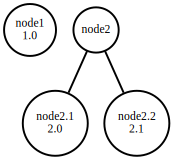

In [36]:
bigraph_state = {
    'node1': 1.0,
    'node2': {
        'node2.1': 2.0,
        'node2.2': 2.1
    }
}
plot_bigraph(bigraph_state, show_values=True)

### Fill state

One of the key advantages of a type system is its ability to improve automation in compositional modeling. The `fill` function exemplifies this by automatically populating missing schema elements. Given a schema and an incomplete instance, the fill function intelligently identifies and fills the missing schema components, ensuring that the instance is compliant with the schema definition.

In [40]:
dual_edge_schema = {
    'edge1': {
        '_ports': {
            'port1': 'float',
            'port2': 'int',
        },
    },
    'edge2': {
        '_ports': {
            'port1': 'float',
            'port2': 'int',
        },
    },
}    

types.type_registry.register(
    'dual_edge',
    dual_edge_schema,
)

schema = {
    'store1': 'dual_edge',
    'edge3': {
        '_ports': {
            'port1': 'dual_edge'
        }
    }
}

instance = {
    'store1': {
        'edge1': {
            'wires': {
                'port1': 'store1.1',
                'port2': 'store1.2',
            }
        },
        'edge2': {
            'wires': {
                'port1': 'store1.1',
                'port2': 'store1.2',
            }
        }
    },
    'edge3': {
        'wires': {
            'port1': 'store1',
        }
    },
}
filled_instance = types.fill(schema, instance)

filled_schema = types.type_registry.access(schema)

In [38]:
print(f'schema:\n {pf(schema)}\n')
print(f'instance:\n {pf(instance)}\n')
print(f'filled schema:\n {pf(filled_schema)}\n')
print(f'filled instance:\n {pf(filled_instance)}\n')

schema:
 {'edge3': {'_ports': {'port1': 'dual_edge'}}, 'store1': 'dual_edge'}

instance:
 { 'edge3': {'wires': {'port1': 'store1'}},
  'store1': { 'edge1': {'wires': {'port1': 'store1.1', 'port2': 'store1.2'}},
              'edge2': {'wires': {'port1': 'store1.1', 'port2': 'store1.2'}}}}

filled schema:
 { 'edge3': { '_ports': { 'port1': { 'edge1': { '_ports': { 'port1': { '_apply': 'accumulate',
                                                                      '_default': '0.0',
                                                                      '_description': '64-bit '
                                                                                      'floating '
                                                                                      'point '
                                                                                      'precision '
                                                                                      'number',
                          

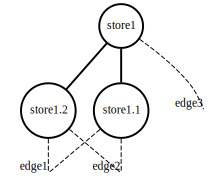

In [39]:
plot_bigraph(filled_instance, collapse_processes=True, remove_process_place_edges=True, port_labels=False)

## Update (TODO)

## Query

Find a schema within a composite. For example find a mitochondria within a cell

## Adapters

Show how adapters can automatically compose into a schema to provide translation between types.